# Libraries

In [55]:
# 📚 Basic Libraries
import pandas as pd
import numpy as np
import warnings

# 📊 Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px

from io import StringIO
import sys
import os
import utils

# 🤖 NLP Libraries
import nltk # natural language toolkit
from nltk.stem import WordNetLemmatizer # lemmatize
from nltk.corpus import wordnet # wordnet is a lexical database for the English language
from tqdm.autonotebook import tqdm, trange
from nltk.corpus import stopwords

nltk.download('punkt_tab')
nltk.download('wordnet') 
nltk.download('omw-1.4')
nltk.download('stopwords')

# 🤖 Sklearn Libraries

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier 

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) 
warnings.filterwarnings('ignore')  

%matplotlib inline

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/debbie/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/debbie/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/debbie/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/debbie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Functions

In [56]:
def tokenize_col_name(df, col_name):
    """
    Tokenizes the text in the specified column of the dataframe and creates a new column
    with the tokenized words. The new column name is called 'token'.""

    Args:
        df (pd.DataFrame): The input dataframe.
        col_name (str): The name of the column to tokenize.
    Returns:
        pd.DataFrame: The dataframe with new tokenized columns added.
    """

    df['token'] = df[col_name].apply(lambda x: nltk.word_tokenize(x) if isinstance(x, str) else [])    
    return df

def keep_only_alphanumeric(df, col_name):
    """
    Cleans the tokens in the specified column of the dataframe by keeping only alphanumeric tokens.
    Creates a new column with the cleaned tokens. The new column name is 'isal'.

    Args:
        df (pd.DataFrame): The input dataframe.
        col_name (str): The name of the column to tokenize.

    Returns:
        pd.DataFrame: The dataframe with the new column added.
    """
    
    # Clean tokens in the column
    df['isal'] = df[col_name].apply(
        lambda tokens: [token for token in tokens if token.isalnum()] if isinstance(tokens, list) else None
    )
    
    return df

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  

def lemmatize_column(df, col_name):
    """
    Lemmatizes the tokens in the specified column of the dataframe and creates a new column
    with the lemmatized words. The new column name is 'lemma'.

    Args:
        df (pd.DataFrame): The input dataframe.
        col_name (str): The name of the column to tokenize.

    Returns:
        pd.DataFrame: The dataframe with the new lemmatized column added.
    """
    lemmatizer = WordNetLemmatizer()
    df['lemma'] = df[col_name].apply(
        lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in nltk.pos_tag(tokens)] if isinstance(tokens, list) else []
    )
    return df

def join_words(df, col_name):
    """
    Joins the tokens in the specified column of the dataframe into a single string.
    Creates a new column with the joined string. The new column name is 'joined'.

    Args:
        df (pd.DataFrame): The input dataframe.
        col_name (str): The name of the column to tokenize.

    Returns:
        pd.DataFrame: The dataframe with object columns transformed to joined strings.
    """

    df['joined'] = df[col_name].apply(lambda row: " ".join(row) if isinstance(row, list) else row)
    return df

def calculate_models_score(X_train, y_train, X_test, y_test, model_object, modelName, doPrint=True):
    model_object.fit(X_train, y_train)
    y_pred = model_object.predict(X_test)
    score = model_object.score(X_test, y_test)
    if doPrint:
        print(f"{modelName} Score: {score:.4f}")
    return score     
   

# Data Upload and Check

In [57]:
# load data
data= pd.read_csv("../dataset/training_data.csv", sep='\t')
df= data.copy()
df.columns = ['target', 'text']    

In [58]:
utils.view_data(df)

Data has 34151 rows and 2 columns with these data types:

target     int64
text      object
dtype: object

Data row sample and full columns:


,target,text
22261,1,for trump\tit was the lost art of the deal
682,0,mccain just brutally called out trump for his ...
19372,1,us senate may vote this week to add penalties ...
22389,1,trump says preparing new executive actions to ...
15156,0,chinese immigrant owes millions for selling co...


In [59]:
# checking for duplicates, NANs and empty strings
utils.check_data(df)

There are 1946 duplicate rows, 0 empty rows and 0 empty spaces
Duplicate Rows:
       target                                               text
677         0                                    thanks to trump
985         0                                                 no
1486        0  mcconnell says he‚ll obstruct any effort to hi...
1533        0  mcconnell says he‚ll obstruct any effort to hi...
1618        0                                   trump freaks out
...       ...                                                ...
34048       1  u.s. house passes sanctions on iran-backed hez...
34052       1  thailand kicks off sumptuous funeral of king b...
34053       1  trump declines to say if he will visit korean ...
34125       1  thailand kicks off sumptuous funeral of king b...
34131       1  under trump plan\trefugees from 11 countries f...

[3812 rows x 2 columns]


Dropping duplicate rows and checking that there are really no duplicate rows

In [60]:
df.drop_duplicates(inplace=True)
utils.check_data(df)

There are 0 duplicate rows, 0 empty rows and 0 empty spaces


### Checking class imbalance

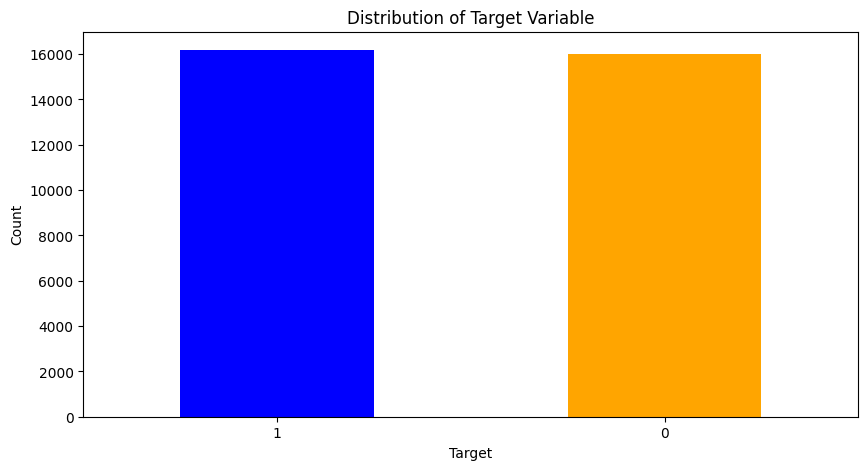

In [61]:
countplot = df["target"].value_counts().plot(kind='bar', figsize=(10, 5), color=['blue', 'orange'])
countplot.set_title('Distribution of Target Variable')
countplot.set_xlabel('Target')
countplot.set_ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [62]:
# tokenizing the news column into a new column
tokenize_col_name(df, 'text')

,target,text,token
0,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus..."
1,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet..."
2,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, obama..."
3,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru..."
4,0,racist alabama cops brutalize black boy while ...,"[racist, alabama, cops, brutalize, black, boy,..."
...,...,...,...
34146,1,tears in rain as thais gather for late king's ...,"[tears, in, rain, as, thais, gather, for, late..."
34147,1,pyongyang university needs non-u.s. teachers a...,"[pyongyang, university, needs, non-u.s., teach..."
34148,1,philippine president duterte to visit japan ah...,"[philippine, president, duterte, to, visit, ja..."
34149,1,japan's abe may have won election\tbut many do...,"[japan, 's, abe, may, have, won, election, but..."


In [63]:
# only keeping what is alphanumeric
keep_only_alphanumeric(df, 'token')

,target,text,token,isal
0,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus..."
1,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, an, internet..."
2,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, obama...","[trump, is, so, obsessed, he, even, has, name,..."
3,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru...","[pope, francis, just, called, out, donald, tru..."
4,0,racist alabama cops brutalize black boy while ...,"[racist, alabama, cops, brutalize, black, boy,...","[racist, alabama, cops, brutalize, black, boy,..."
...,...,...,...,...
34146,1,tears in rain as thais gather for late king's ...,"[tears, in, rain, as, thais, gather, for, late...","[tears, in, rain, as, thais, gather, for, late..."
34147,1,pyongyang university needs non-u.s. teachers a...,"[pyongyang, university, needs, non-u.s., teach...","[pyongyang, university, needs, teachers, as, t..."
34148,1,philippine president duterte to visit japan ah...,"[philippine, president, duterte, to, visit, ja...","[philippine, president, duterte, to, visit, ja..."
34149,1,japan's abe may have won election\tbut many do...,"[japan, 's, abe, may, have, won, election, but...","[japan, abe, may, have, won, election, but, ma..."


In [64]:
# lammatizing the last column
lemmatize_column(df, 'isal')

,target,text,token,isal,lemma
0,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus...","[drunk, brag, trump, staffer, start, russian, ..."
1,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, become, an, internet,..."
2,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, obama...","[trump, is, so, obsessed, he, even, has, name,...","[trump, be, so, obsessed, he, even, have, name..."
3,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru...","[pope, francis, just, called, out, donald, tru...","[pope, francis, just, call, out, donald, trump..."
4,0,racist alabama cops brutalize black boy while ...,"[racist, alabama, cops, brutalize, black, boy,...","[racist, alabama, cops, brutalize, black, boy,...","[racist, alabama, cop, brutalize, black, boy, ..."
...,...,...,...,...,...
34146,1,tears in rain as thais gather for late king's ...,"[tears, in, rain, as, thais, gather, for, late...","[tears, in, rain, as, thais, gather, for, late...","[tear, in, rain, a, thai, gather, for, late, k..."
34147,1,pyongyang university needs non-u.s. teachers a...,"[pyongyang, university, needs, non-u.s., teach...","[pyongyang, university, needs, teachers, as, t...","[pyongyang, university, need, teacher, a, trav..."
34148,1,philippine president duterte to visit japan ah...,"[philippine, president, duterte, to, visit, ja...","[philippine, president, duterte, to, visit, ja...","[philippine, president, duterte, to, visit, ja..."
34149,1,japan's abe may have won election\tbut many do...,"[japan, 's, abe, may, have, won, election, but...","[japan, abe, may, have, won, election, but, ma...","[japan, abe, may, have, win, election, but, ma..."


In [65]:
# joining the words into a single string
join_words(df, 'lemma')

,target,text,token,isal,lemma,joined
0,0,drunk bragging trump staffer started russian c...,"[drunk, bragging, trump, staffer, started, rus...","[drunk, bragging, trump, staffer, started, rus...","[drunk, brag, trump, staffer, start, russian, ...",drunk brag trump staffer start russian collusi...
1,0,sheriff david clarke becomes an internet joke ...,"[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, becomes, an, internet...","[sheriff, david, clarke, become, an, internet,...",sheriff david clarke become an internet joke f...
2,0,trump is so obsessed he even has obama‚s name ...,"[trump, is, so, obsessed, he, even, has, obama...","[trump, is, so, obsessed, he, even, has, name,...","[trump, be, so, obsessed, he, even, have, name...",trump be so obsessed he even have name cod int...
3,0,pope francis just called out donald trump duri...,"[pope, francis, just, called, out, donald, tru...","[pope, francis, just, called, out, donald, tru...","[pope, francis, just, call, out, donald, trump...",pope francis just call out donald trump during...
4,0,racist alabama cops brutalize black boy while ...,"[racist, alabama, cops, brutalize, black, boy,...","[racist, alabama, cops, brutalize, black, boy,...","[racist, alabama, cop, brutalize, black, boy, ...",racist alabama cop brutalize black boy while h...
...,...,...,...,...,...,...
34146,1,tears in rain as thais gather for late king's ...,"[tears, in, rain, as, thais, gather, for, late...","[tears, in, rain, as, thais, gather, for, late...","[tear, in, rain, a, thai, gather, for, late, k...",tear in rain a thai gather for late king funeral
34147,1,pyongyang university needs non-u.s. teachers a...,"[pyongyang, university, needs, non-u.s., teach...","[pyongyang, university, needs, teachers, as, t...","[pyongyang, university, need, teacher, a, trav...",pyongyang university need teacher a travel ban...
34148,1,philippine president duterte to visit japan ah...,"[philippine, president, duterte, to, visit, ja...","[philippine, president, duterte, to, visit, ja...","[philippine, president, duterte, to, visit, ja...",philippine president duterte to visit japan ah...
34149,1,japan's abe may have won election\tbut many do...,"[japan, 's, abe, may, have, won, election, but...","[japan, abe, may, have, won, election, but, ma...","[japan, abe, may, have, win, election, but, ma...",japan abe may have win election but many do wa...


# Model Training

In [66]:
# setting the X to the cleaned text column and Y to the target
X = df['joined'] 
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [67]:
# Strings needs to be vestorized to be used in ML models
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

## Testing accuracy of different models

In [68]:
# Logistic regression model
log_reg_score = calculate_models_score(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                                       LogisticRegression(max_iter=1000), "Logistic Regression")
# KNN model
knn_score = calculate_models_score(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                                       KNeighborsClassifier(n_neighbors=11), "KNearest Neighbors")

# Gradient Boosting Classifier
gbc_score = calculate_models_score(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                                       GradientBoostingClassifier(), "Gradient Boosting Classifier")
# Random Forest Classifier               
rfc_score = calculate_models_score(X_train_tfidf, y_train, X_test_tfidf, y_test, 
                                       RandomForestClassifier(), "Random Forest Classifier")

Logistic Regression Score: 0.9215
KNearest Neighbors Score: 0.5149
Gradient Boosting Classifier Score: 0.7988
Random Forest Classifier Score: 0.9014


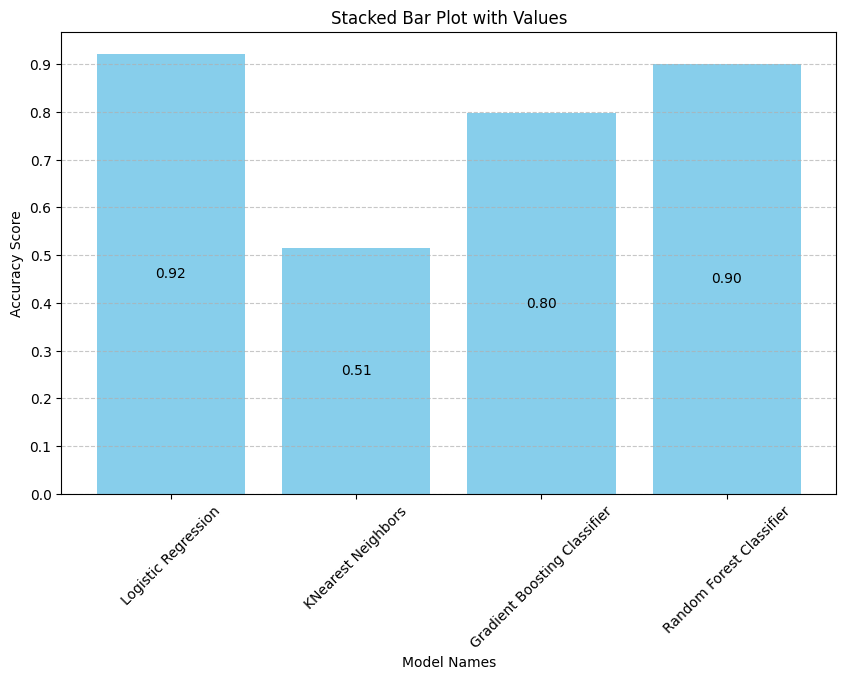

In [82]:
# Data for the stacked bar plot
model_name = ['Logistic Regression', 'KNearest Neighbors', 'Gradient Boosting Classifier', 'Random Forest Classifier']
score = [log_reg_score, knn_score, gbc_score, rfc_score]

# Create a stacked bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_name, score, color='skyblue')

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate score in the center of the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{height:.2f}', ha='center', va='center', color='black')

plt.yticks(np.arange(0, max(score), 0.1))

# Add labels and title
plt.title('Stacked Bar Plot with Values')
plt.xlabel('Model Names')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45)
plt.show()

# Run best model on testing_data.csv

In [69]:
# load data
data= pd.read_csv("../dataset/testing_data.csv", sep='\t')
df_test= data.copy()
df_test.columns = ['prediction', 'text']   

In [ ]:
# training the model on the entire dataset and running it on the unknown data set
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(df['joined'])

model = LogisticRegression(max_iter=1000)
model.fit(X, df['target'])

X_for_prediction = vectorizer.fit_transform(df_test['text'])
df_test['prediction'] = model.predict(X_for_prediction)

In [ ]:
# saving the predictions to a csv file
df_test.to_csv("../dataset/test_predictions.csv", sep='\t', index=False)